In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import osmnx as ox
import numpy as np
import requests
import json

In [2]:
# import rail isochrones
rail_isochrone = gpd.read_file(os.path.join('data','cleaned','rail_isochrone_15m.gpkg'),crs='EPSG:27700')
rail_isochrone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   400 non-null    int64   
 1   name      400 non-null    object  
 2   pt_type   400 non-null    object  
 3   geometry  400 non-null    geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 12.6+ KB


In [3]:
# import bus isochrones
bus_isochrone = gpd.read_file(os.path.join('data','cleaned','bus_isochrone_15m.gpkg'),crs='EPSG:27700')
bus_isochrone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18526 entries, 0 to 18525
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   18526 non-null  object  
 1   name      18526 non-null  object  
 2   pt_type   18526 non-null  object  
 3   geometry  18526 non-null  geometry
dtypes: geometry(1), object(3)
memory usage: 579.1+ KB


In [9]:
# add prefix to column id_code of each df
rail_isochrone['id_code'] = 'R_' + rail_isochrone['id_code'].astype(str)
bus_isochrone['id_code'] = 'B_' + bus_isochrone['id_code'].astype(str)

In [13]:
# concatenate isochrones
isochrones = pd.concat([rail_isochrone,bus_isochrone])

In [14]:
df = pd.read_csv(os.path.join('data','Station - 2011-12.csv'))
df = df[df['County or Unitary Authority'] == 'Greater London'] # Filter for London
# create new column for postcode, trim last 3 characters of the location for map
df['Postcode'] = df['Location for map'].str[:-4]
# remove London Underground and London Overground stations in Station Facility Owner
df = df[~df['Station Facility Owner'].str.contains('London Underground')]
df = df[~df['Station Facility Owner'].str.contains('London Overground')]
df.head()

,NLC,Origin TLC,Station Name,Location for map,Government Office Region (GOR),County or Unitary Authority,District or Unitary Authority,NUTS2 Spatial_Unit Code,NUTS2 Spatial Unit,Station Facility Owner,London Travelcard Area,Postcode
0,7492,BKG,Barking,"IG11 8TU, UK",London,Greater London,Barking And Dagenham,UKI2,Outer London,c2c,London Travelcard Area Station,IG11 8TU
19,7440,DDK,Dagenham Dock,"RM9 6PT, UK",London,Greater London,Barking And Dagenham,UKI2,Outer London,c2c,London Travelcard Area Station,RM9 6PT
20,7491,LHS,Limehouse,"E14 7JD, UK",London,Greater London,Tower Hamlets,UKI1,Inner London,c2c,London Travelcard Area Station,E14 7JD
33,7454,RNM,Rainham (Essex),"RM13 9HY, UK",London,Greater London,Havering,UKI2,Outer London,c2c,London Travelcard Area Station,RM13 9HY
39,7464,UPM,Upminster,"RM14 2TD, UK",London,Greater London,Havering,UKI2,Outer London,c2c,London Travelcard Area Station,RM14 2TD


In [15]:
df['Station Facility Owner'].value_counts()

Station Facility Owner
Southeastern                    68
Southern                        51
National Express East Anglia    40
South West Trains               39
First Capital Connect           37
Network Rail                    11
First Great Western             10
Chiltern Railways                7
c2c                              6
Name: count, dtype: int64

In [16]:
def get_lat_long(postcode):
    url = f'https://api.postcodes.io/postcodes/{postcode}'
    response = requests.get(url)
    if response.status_code == 200:
        data = json.loads(response.text)
        return data['result']['latitude'], data['result']['longitude']
    else:
        return np.nan, np.nan
    
# test function
df['Latlon'] = df['Postcode'].apply(get_lat_long) 
df.head()   

,NLC,Origin TLC,Station Name,Location for map,Government Office Region (GOR),County or Unitary Authority,District or Unitary Authority,NUTS2 Spatial_Unit Code,NUTS2 Spatial Unit,Station Facility Owner,London Travelcard Area,Postcode,Latlon
0,7492,BKG,Barking,"IG11 8TU, UK",London,Greater London,Barking And Dagenham,UKI2,Outer London,c2c,London Travelcard Area Station,IG11 8TU,"(51.539322, 0.080979)"
19,7440,DDK,Dagenham Dock,"RM9 6PT, UK",London,Greater London,Barking And Dagenham,UKI2,Outer London,c2c,London Travelcard Area Station,RM9 6PT,"(nan, nan)"
20,7491,LHS,Limehouse,"E14 7JD, UK",London,Greater London,Tower Hamlets,UKI1,Inner London,c2c,London Travelcard Area Station,E14 7JD,"(51.512605, -0.040203)"
33,7454,RNM,Rainham (Essex),"RM13 9HY, UK",London,Greater London,Havering,UKI2,Outer London,c2c,London Travelcard Area Station,RM13 9HY,"(51.512476, 0.20085)"
39,7464,UPM,Upminster,"RM14 2TD, UK",London,Greater London,Havering,UKI2,Outer London,c2c,London Travelcard Area Station,RM14 2TD,"(51.558504, 0.250535)"


In [17]:
# geo data frame
df[['Latitude','Longitude']] = pd.DataFrame(df['Latlon'].tolist(), index=df.index)
rail_opt = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326')
rail_opt = rail_opt.to_crs('EPSG:27700')

rail_opt = rail_opt[['NLC','Station Name','Station Facility Owner','geometry']]

# rename columns
rail_opt.columns = ['nlc','name','operator','geometry']
rail_opt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 269 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   nlc       269 non-null    int64   
 1   name      269 non-null    object  
 2   operator  269 non-null    object  
 3   geometry  269 non-null    geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 10.5+ KB


In [18]:
# TFL stations
df1 = pd.read_csv(os.path.join('data','numbat_geometry.csv'))
# GEO data frame
df1['geometry'] = gpd.GeoSeries.from_wkt(df1['geometry'])
rail_opt_tfl = gpd.GeoDataFrame(df1, crs='EPSG:4326')
rail_opt_tfl = rail_opt_tfl.to_crs('EPSG:27700')
rail_opt_tfl['operator'] = 'TfL'
rail_opt_tfl = rail_opt_tfl.drop(columns=['asc'])
# rename columns
rail_opt_tfl.columns = ['nlc','name','geometry','operator']
rail_opt_tfl.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   nlc       432 non-null    int64   
 1   name      432 non-null    object  
 2   geometry  432 non-null    geometry
 3   operator  432 non-null    object  
dtypes: geometry(1), int64(1), object(2)
memory usage: 13.6+ KB


In [19]:
# concat
rail_stn_op = pd.concat([rail_opt,rail_opt_tfl],ignore_index=True)
rail_stn_op = rail_stn_op[rail_stn_op['geometry'].is_empty == False]
rail_stn_op.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 668 entries, 0 to 700
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   nlc       668 non-null    int64   
 1   name      668 non-null    object  
 2   operator  668 non-null    object  
 3   geometry  668 non-null    geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 26.1+ KB


In [20]:
bus_route = gpd.read_file(os.path.join('data','cleaned','flow_bus_byStopRoutes.gpkg'))
bus_route.to_crs('EPSG:27700',inplace=True)
bus_route.head()

,stop_id,stop_name,route_id,n_alighters,ROUTES,geometry
0,1000,Westminster Stn / Parliament Square,12,38.75,"12, 159, 453, N53, N109, N155, N381",POINT (530171.001 179738.000)
1,1000,Westminster Stn / Parliament Square,159,58.25,"12, 159, 453, N53, N109, N155, N381",POINT (530171.001 179738.000)
2,1000,Westminster Stn / Parliament Square,35,1.00,"12, 159, 453, N53, N109, N155, N381",POINT (530171.001 179738.000)
3,1000,Westminster Stn / Parliament Square,453,88.75,"12, 159, 453, N53, N109, N155, N381",POINT (530171.001 179738.000)
4,1000,Westminster Stn / Parliament Square,N109,1.00,"12, 159, 453, N53, N109, N155, N381",POINT (530171.001 179738.000)


In [21]:
# loop through each isochrone
for i, isochrone in isochrones.iterrows():
    # create a list to store the route_ids
    route_ids = []
    # get the stops that are within the isochrone
    stops_within = bus_route[bus_route.geometry.within(isochrone.geometry)]
    # get the route_ids for those stops
    route_ids.extend(stops_within['route_id'].unique())
    route_ids = list(set(route_ids))
    # create new column in the original df to store the route_ids
    isochrones.loc[i,'route_ids'] = str(route_ids)
    # print the progress
    print(f'{i}/{len(isochrones)}')

0/18926
1/18926
2/18926
3/18926
4/18926
5/18926
6/18926
7/18926
8/18926
9/18926
10/18926
11/18926
12/18926
13/18926
14/18926
15/18926
16/18926
17/18926
18/18926
19/18926
20/18926
21/18926
22/18926
23/18926
24/18926
25/18926
26/18926
27/18926
28/18926
29/18926
30/18926
31/18926
32/18926
33/18926
34/18926
35/18926
36/18926
37/18926
38/18926
39/18926
40/18926
41/18926
42/18926
43/18926
44/18926
45/18926
46/18926
47/18926
48/18926
49/18926
50/18926
51/18926
52/18926
53/18926
54/18926
55/18926
56/18926
57/18926
58/18926
59/18926
60/18926
61/18926
62/18926
63/18926
64/18926
65/18926
66/18926
67/18926
68/18926
69/18926
70/18926
71/18926
72/18926
73/18926
74/18926
75/18926
76/18926
77/18926
78/18926
79/18926
80/18926
81/18926
82/18926
83/18926
84/18926
85/18926
86/18926
87/18926
88/18926
89/18926
90/18926
91/18926
92/18926
93/18926
94/18926
95/18926
96/18926
97/18926
98/18926
99/18926
100/18926
101/18926
102/18926
103/18926
104/18926
105/18926
106/18926
107/18926
108/18926
109/18926
110/18926


In [22]:
# loop through each isochrone
for i, isochrone in isochrones.iterrows():
    # create a list to store the route_ids
    route_ids1 = []
    # get the stops that are within the isochrone
    stops_within = rail_stn_op[rail_stn_op.geometry.within(isochrone.geometry)]
    # get the route_ids for those stops
    route_ids1.extend(stops_within['operator'].unique())
    route_ids1 = list(set(route_ids1))
    # create new column in the original df to store the route_ids
    isochrones.loc[i,'route_ids1'] = str(route_ids1)
    # print the progress
    print(f'{i}/{len(isochrones)}')

0/18926
1/18926
2/18926
3/18926
4/18926
5/18926
6/18926
7/18926
8/18926
9/18926
10/18926
11/18926
12/18926
13/18926
14/18926
15/18926
16/18926
17/18926
18/18926
19/18926
20/18926
21/18926
22/18926
23/18926
24/18926
25/18926
26/18926
27/18926
28/18926
29/18926
30/18926
31/18926
32/18926
33/18926
34/18926
35/18926
36/18926
37/18926
38/18926
39/18926
40/18926
41/18926
42/18926
43/18926
44/18926
45/18926
46/18926
47/18926
48/18926
49/18926
50/18926
51/18926
52/18926
53/18926
54/18926
55/18926
56/18926
57/18926
58/18926
59/18926
60/18926
61/18926
62/18926
63/18926
64/18926
65/18926
66/18926
67/18926
68/18926
69/18926
70/18926
71/18926
72/18926
73/18926
74/18926
75/18926
76/18926
77/18926
78/18926
79/18926
80/18926
81/18926
82/18926
83/18926
84/18926
85/18926
86/18926
87/18926
88/18926
89/18926
90/18926
91/18926
92/18926
93/18926
94/18926
95/18926
96/18926
97/18926
98/18926
99/18926
100/18926
101/18926
102/18926
103/18926
104/18926
105/18926
106/18926
107/18926
108/18926
109/18926
110/18926


In [24]:
from scipy.stats import entropy


In [31]:
# iterate through each row
for i, row in isochrones.iterrows():
    # convert the string back to a list
    c = eval(row['route_ids'])
    d = eval(row['route_ids1'])
    # combine the two lists
    c.extend(d)
    # count the frequency of each element, then calculate the probability, put it in a list
    c = np.array([c.count(x) for x in set(c)])
    c = c[c != 0]
    c = c / c.sum()
    # calculate the entropy
    ent = entropy(c)
    # add to the original df
    isochrones.loc[i,'transp_opt_entropy'] = ent

    # print the progress
    print(f'{i}/{len(isochrones)}')

isochrones.head()   

0/18926
1/18926
2/18926
3/18926
4/18926
5/18926
6/18926
7/18926
8/18926
9/18926
10/18926
11/18926
12/18926
13/18926
14/18926
15/18926
16/18926
17/18926
18/18926
19/18926
20/18926
21/18926
22/18926
23/18926
24/18926
25/18926
26/18926
27/18926
28/18926
29/18926
30/18926
31/18926
32/18926
33/18926
34/18926
35/18926
36/18926
37/18926
38/18926
39/18926
40/18926
41/18926
42/18926
43/18926
44/18926
45/18926
46/18926
47/18926
48/18926
49/18926
50/18926
51/18926
52/18926
53/18926
54/18926
55/18926
56/18926
57/18926
58/18926
59/18926
60/18926
61/18926
62/18926
63/18926
64/18926
65/18926
66/18926
67/18926
68/18926
69/18926
70/18926
71/18926
72/18926
73/18926
74/18926
75/18926
76/18926
77/18926
78/18926
79/18926
80/18926
81/18926
82/18926
83/18926
84/18926
85/18926
86/18926
87/18926
88/18926
89/18926
90/18926
91/18926
92/18926
93/18926
94/18926
95/18926
96/18926
97/18926
98/18926
99/18926
100/18926
101/18926
102/18926
103/18926
104/18926
105/18926
106/18926
107/18926
108/18926
109/18926
110/18926


,id_code,name,pt_type,geometry,route_ids,route_ids1,transp_mode_entropy,transp_opt_entropy
0,R_750,Abbey Road,rail,"POLYGON ((538894.554 183025.869, 538893.934 18...","['N24', 'N136', 'N551', '148', 'N11', 'N113', ...",['TfL'],3.737670,3.737670
1,R_5131,Abbey Wood,rail,"POLYGON ((546817.720 178994.762, 546815.775 17...","['110', '267', 'H22', '281', 'H20', '481', 'N2...",[],1.945910,1.945910
2,R_1404,Acton Central,rail,"POLYGON ((520076.256 180087.693, 520076.059 18...","['N19', 'N43', '30', 'N271', '277', '19', '153...","['First Capital Connect', 'TfL']",2.833213,2.833213
3,R_3000,Acton Main Line,rail,"POLYGON ((520167.664 180775.840, 520165.727 18...","['N19', 'N43', '30', 'N271', '277', '19', '153...","['First Capital Connect', 'TfL']",2.833213,2.833213
4,R_500,Acton Town,rail,"POLYGON ((518842.951 178561.693, 518840.651 17...","['N19', 'N43', 'N271', '58', '19', '153', '4',...","['First Capital Connect', 'TfL']",2.708050,2.708050


<Axes: title={'center': 'Top 10% PT operator diversity'}>

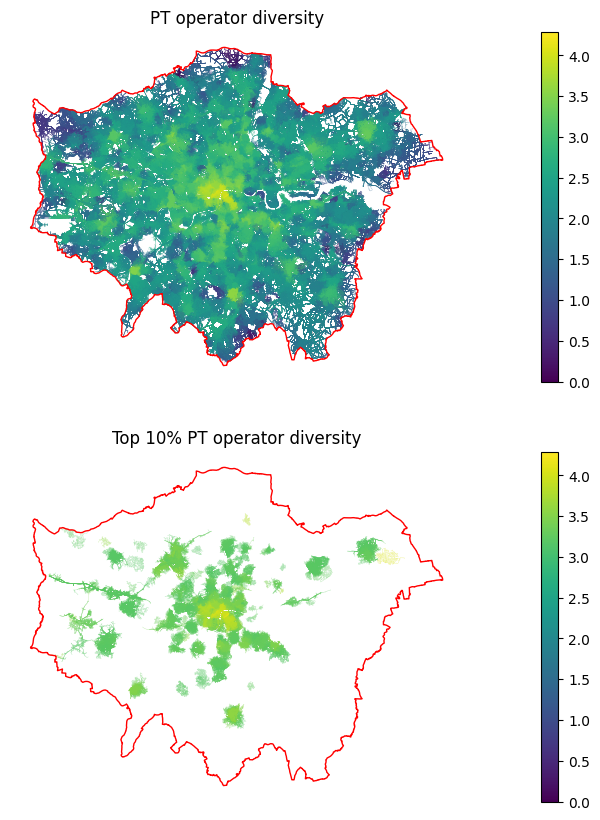

In [32]:
fig, ax = plt.subplots(2,1,figsize=(20,10))

vmin = isochrones.transp_opt_entropy.min()
vmax = isochrones.transp_opt_entropy.max()

isochrones.plot(column='transp_opt_entropy', 
           ax=ax[0],
           legend=True, 
           alpha=0.5, 
           cmap='viridis',vmin=vmin,vmax=vmax
           ).set_title('PT operator diversity')
ax[0].axis('off')

isochrones[isochrones.transp_opt_entropy > isochrones.transp_opt_entropy.quantile(0.90)].plot(
            column='transp_opt_entropy', 
            ax=ax[1],
            legend=True,
            alpha=0.5,
            cmap='viridis',vmin=vmin,vmax=vmax
            ).set_title('Top 10% PT operator diversity')
ax[1].axis('off')

# london boundary from osm
london = ox.geocode_to_gdf('Greater London, UK')
london.to_crs(epsg=27700, inplace=True)
london.boundary.plot(ax=ax[0], color='red', linewidth=1)
london.boundary.plot(ax=ax[1], color='red', linewidth=1)

In [33]:
isochrones_df = isochrones[['id_code','transp_opt_entropy']]
isochrones_df.reset_index(drop=True,inplace=True)

In [34]:
#export gdf
isochrones_df.to_csv(os.path.join('data','cleaned','transp_opt_isochrones.csv'),index=False)